## Set data Path

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
flightData2015 = 'data/flight-data/csv/2015-summary.csv'
retailDataDay = 'data/retail-data/by-day/'

## What is Apache Spark?

-  Unified computing engine for parallel data processing distributed across clusters (machine nodes)   
<br>
    -  **Structured APIs**:
        -  Datasets
        -  DataFrames
        -  SQL   
        <br>
    -  **Unstructured APIs**:
        -  RDDs   
        <br>
    -  **Libraries**:
        -  Structured Streaming
        -  Machine Learning
        -  Graph   
        <br>
    -  **Resource Manager**:
        -  Local
        -  Standalone (Cluster)
        -  YARN (Cluster)
        -  Mesos (Cluster)   
        <br>
    -  **Language APIs**:
        -  Scala
        -  Java
        -  Python
        -  SQL
        -  R

## Introduction to Spark_

-  **Spark Applications**:
    -  **Driver** (heart of Spark Application during application's lifecycle):
        -  maintains information about Spark Application
        -  responds to user's program / input
        -  distributes and schedules work across executors   
        <br>
    -  **Executors**:
        -  executes work (code) assigned by driver
        -  reports state of work execution back to driver node   
        <br>
    -  **SparkSession**:
        -  entry point that manages Spark Application via driver process   
        <br>
    -  **DataFrames**:
        -  represents a table of data with rows and columns
        -  compiled in a schema that defines the column labels and data types   
        <br>
    -  **Partitions**:
        -  chunks of data distributed across cluster for parallel execution
        -  in addition, a collection of rows sitting on one physical machine in cluster
        -  parallelism = partitions = executors (x: 1 partition / 1,000 executors = parallelism of 1; 1,000 paritions / 1 executors = parallelism of 1)   
        <br>
    -  **Lazy Evaluation**:
        -  bundles plan of transformations on source data into DAG then triggers DAG on action
        -  molds a logical plan into a pysical plan that will run across cluster   
        <br>
    -  **Transformations**:
         -  data manipulations and modifications   
            <br>
             -  **Narrow Transformations** (1 to 1):
                 -  each input partition will contribute to only one output partition
                 -  no dependencies => 1 parent w/ 1 child
                 -  ex: filter, maps   
                <br>
             -  **Wide Transformations** (1 to N):
                  -  "aka" shuffle
                  -  many dependencies => 1 parent w/ many children
                  -  each input partition will contribute to many output partitions across the cluster
                  -  **when a shuffle occurs Spark writes the results to disk** ex: spark.sql.shuffle.partitions
                  -  ex: aggregations, joins, groupings   
       <br>           
    -  **Actions**:
        -  triggers the series of transformations into a spark job
            -  types:
                -  view data in the console
                -  collect data
                -  write to output data sources

   -  Spark Job (represents set of transformations triggered by an individual action)
   -  Schema Inference (have Spark best guess the schema of data) ***triggers Spark Job when scanning through data***
   -  Spark-Submit (launches application code to a cluster)
   -  Catalyst (planning and processing of work engine)

### Note: Spark contains separate Python and R processes hence when using Spark from Python or R language API the Python or R code is transaled into code that Spark can run on the executor JVMs_

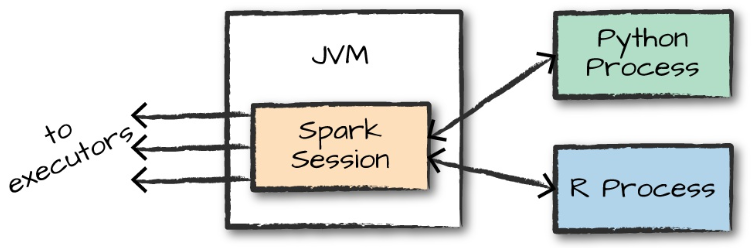

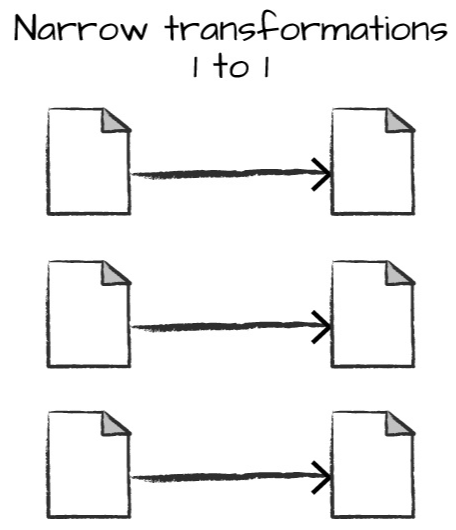

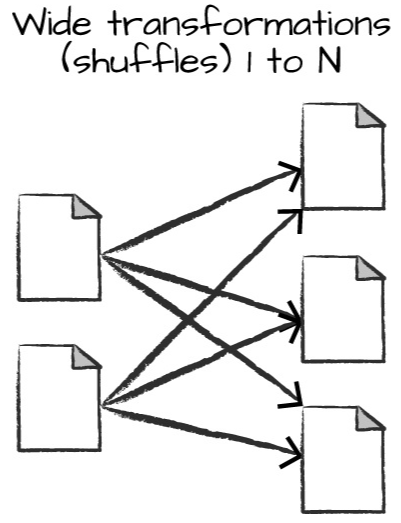

### Practicals

In [12]:
flightDataDF2015 = spark\
.read\
.option("inferSchema", "true")\
.option("header", "true")\
.csv(flightData2015)

In [9]:
flightDataDF2015.rdd.getNumPartitions()

1

In [13]:
flightDataDF2015.take(3)

[Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Ireland', count=344)]

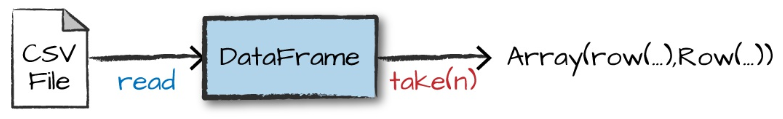

-  **Explain Plan**:
    -  displays DFs lineage

In [15]:
flightDataDF2015.sort("count").explain()

== Physical Plan ==
*(1) Sort [count#48 ASC NULLS FIRST], true, 0
+- *(1) Project [DEST_COUNTRY_NAME#46, ORIGIN_COUNTRY_NAME#47, count#48]
   +- BatchScan[DEST_COUNTRY_NAME#46, ORIGIN_COUNTRY_NAME#47, count#48] CSVScan Location: InMemoryFileIndex[file:/home/jupyterhub/sparkTheDefinitiveGuide/data/flight-data/csv/2015-summary..., ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>




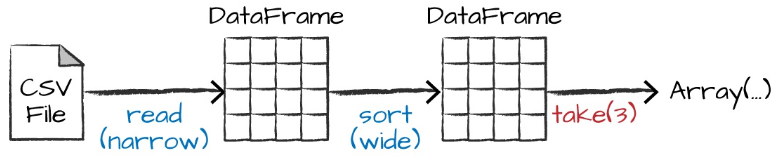

-  **SPARK.SQL.SHUFFLE.PARTITIONS**:
    -  by default, there are 200 shuffle partitions

In [16]:
spark.conf.set("spark.sql.shuffle.partitions", "5")

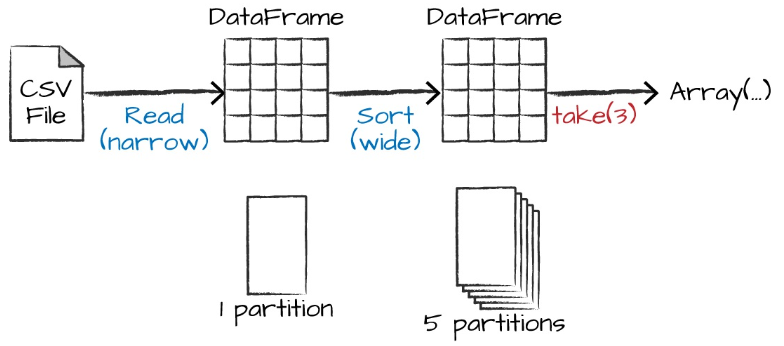

In [70]:
flightDataDF2015.sort("count").explain(True)

== Parsed Logical Plan ==
'Sort ['count ASC NULLS FIRST], true
+- Relation[DEST_COUNTRY_NAME#190,ORIGIN_COUNTRY_NAME#191,count#192] csv

== Analyzed Logical Plan ==
DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: int
Sort [count#192 ASC NULLS FIRST], true
+- Relation[DEST_COUNTRY_NAME#190,ORIGIN_COUNTRY_NAME#191,count#192] csv

== Optimized Logical Plan ==
Sort [count#192 ASC NULLS FIRST], true
+- Relation[DEST_COUNTRY_NAME#190,ORIGIN_COUNTRY_NAME#191,count#192] csv

== Physical Plan ==
*Sort [count#192 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(count#192 ASC NULLS FIRST, 5)
   +- *FileScan csv [DEST_COUNTRY_NAME#190,ORIGIN_COUNTRY_NAME#191,count#192] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/spark/spark-2.2.0-bin-hadoop2.7/plutopy/plutopy/sparkTheDefinitiveGu..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>


In [17]:
flightDataDF2015.createOrReplaceTempView("flight_data_2015")

In [18]:
sqlWay = spark\
.sql("""
select dest_country_name, count(1)
from flight_data_2015
group by dest_country_name
""")

In [19]:
dataFrameWay = flightDataDF2015\
.groupBy("dest_country_name")\
.count()

In [22]:
sqlWay.explain()
dataFrameWay.explain()

== Physical Plan ==
*(1) HashAggregate(keys=[dest_country_name#46], functions=[count(1)])
+- *(1) HashAggregate(keys=[dest_country_name#46], functions=[partial_count(1)])
   +- *(1) Project [DEST_COUNTRY_NAME#46]
      +- BatchScan[DEST_COUNTRY_NAME#46] CSVScan Location: InMemoryFileIndex[file:/home/jupyterhub/sparkTheDefinitiveGuide/data/flight-data/csv/2015-summary..., ReadSchema: struct<DEST_COUNTRY_NAME:string>


== Physical Plan ==
*(1) HashAggregate(keys=[dest_country_name#46], functions=[count(1)])
+- *(1) HashAggregate(keys=[dest_country_name#46], functions=[partial_count(1)])
   +- *(1) Project [DEST_COUNTRY_NAME#46]
      +- BatchScan[DEST_COUNTRY_NAME#46] CSVScan Location: InMemoryFileIndex[file:/home/jupyterhub/sparkTheDefinitiveGuide/data/flight-data/csv/2015-summary..., ReadSchema: struct<DEST_COUNTRY_NAME:string>




In [23]:
from pyspark.sql.functions import desc

In [25]:
flightDataDF2015\
.groupBy("dest_country_name")\
.sum("count")\
.withColumnRenamed("sum(count)", "destination_total")\
.sort(desc("destination_total"))\
.limit(5)\
.explain()

== Physical Plan ==
TakeOrderedAndProject(limit=5, orderBy=[destination_total#109L DESC NULLS LAST], output=[dest_country_name#46,destination_total#109L])
+- *(1) HashAggregate(keys=[dest_country_name#46], functions=[sum(cast(count#48 as bigint))])
   +- *(1) HashAggregate(keys=[dest_country_name#46], functions=[partial_sum(cast(count#48 as bigint))])
      +- *(1) Project [DEST_COUNTRY_NAME#46, count#48]
         +- BatchScan[DEST_COUNTRY_NAME#46, count#48] CSVScan Location: InMemoryFileIndex[file:/home/jupyterhub/sparkTheDefinitiveGuide/data/flight-data/csv/2015-summary..., ReadSchema: struct<DEST_COUNTRY_NAME:string,count:int>




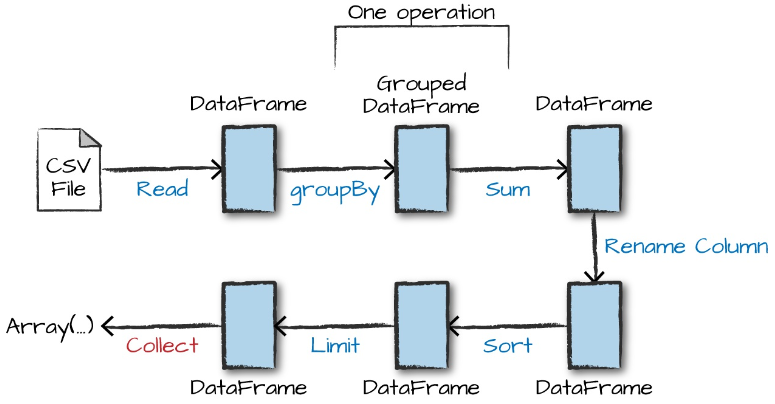

In [27]:
flightDataDF2015\
.groupBy("dest_country_name")\
.sum("count")\
.withColumnRenamed("sum(count)", "destination_total")\
.sort(desc("destination_total"))\
.limit(3)\
.show()

+-----------------+-----------------+
|dest_country_name|destination_total|
+-----------------+-----------------+
|    United States|           411352|
|           Canada|             8399|
|           Mexico|             7140|
+-----------------+-----------------+



## A Tour of Spark's Toolset

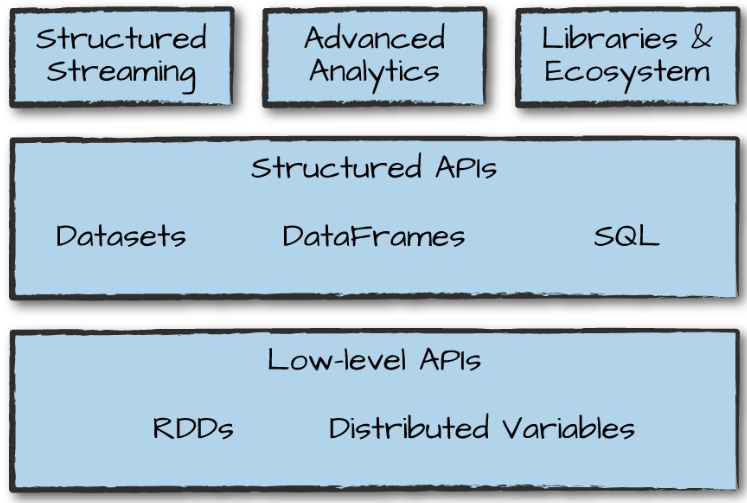

## Running Production Applications

 - Spark makes it easy to develop and create big data programs. 
 - Spark also makes it easy to turn your interactive exploration into production applications with spark-submit
 - spark-submit is a built-in command-line tool. 
 - spark-submit does one thing: it lets you send your application code to a cluster and launch it to execute there. 
 - Upon submission, the application will run until it exits (completes the task) or encounters an error.
 - You can do this with all of Spark’s support cluster managers including Standalone, Mesos, and YARN. 

-  **Structured Streaming**:
    -  read streams
    -  window functions
    -  triggers
    -  write streams

- Structured Streaming is a high-level API for stream processing
- With Structured Streaming, you can take the same operations that you perform in batch mode using Spark’s structured APIs and run them in a streaming fashion.
- This can reduce latency and allow for incremental processing

In [3]:
print(retailDataDay)

data/retail-data/by-day/


In [4]:
staticDataFrame = spark\
.read\
.format("csv")\
.option("header", "true")\
.option("inferSchema", "true")\
.load(retailDataDay)

In [5]:
staticDataFrame.createOrReplaceTempView("retail_data")
staticSchema = staticDataFrame.schema

In [6]:
from pyspark.sql.functions import window, column, desc, col

In [7]:
staticDataFrame\
.selectExpr(\
           "CustomerId",
           "(UnitPrice * Quantity) as total_cost",\
           "InvoiceDate")\
.groupBy(\
        col("CustomerId"), window(col("InvoiceDate"), "1 day"))\
.sum("total_cost")\
.show(3)

+----------+--------------------+-----------------+
|CustomerId|              window|  sum(total_cost)|
+----------+--------------------+-----------------+
|   16057.0|[2011-12-05 00:00...|            -37.6|
|   14126.0|[2011-11-29 00:00...|643.6300000000001|
|   13500.0|[2011-11-16 00:00...|497.9700000000001|
+----------+--------------------+-----------------+
only showing top 3 rows



In [8]:
streamingDataFrame = spark\
.readStream\
.schema(staticSchema)\
.option("maxFilesPerTrigger", 1)\
.format("csv")\
.option("header", "true")\
.load(retailDataDay)

In [9]:
print(streamingDataFrame.isStreaming)

True


### Window Function - Find days when the customer buys the most
- Take a look at the sale hours during which a given customer makes a large purchase. 
- Let’s add a total cost column and see on what days a customer spent the most.

- The window function will include all data from each day in the aggregation

In [10]:
purchaseByCustomerPerHour = streamingDataFrame\
.selectExpr(\
           "CustomerId",
           "(UnitPrice * Quantity) as total_cost",\
           "InvoiceDate")\
.groupBy(\
        col("CustomerId"), window(col("InvoiceDate"), "1 day"))\
.sum("total_cost")

In [11]:
purchaseByCustomerPerHour.writeStream\
.format("memory")\
.queryName("customer_purchases")\
.outputMode("complete")\
.start()


In [12]:
from time import sleep
sleep(10)

In [13]:
spark.sql("""
select *
from customer_purchases
order by 'sum(total_cost)' desc""")\
.show(3, truncate=False)

+----------+------------------------------------------+---------------------+
|CustomerId|window                                    |sum(total_cost)      |
+----------+------------------------------------------+---------------------+
|15674.0   |[2011-04-05 00:00:00, 2011-04-06 00:00:00]|4.973799150320701E-14|
|17841.0   |[2011-04-05 00:00:00, 2011-04-06 00:00:00]|197.06               |
|14849.0   |[2011-04-05 00:00:00, 2011-04-06 00:00:00]|422.3400000000001    |
+----------+------------------------------------------+---------------------+
only showing top 3 rows



### Machine Learning

-  **Machine Learning**:
    -  numerical representation
    -  data cleansing
    -  train / test split
    -  feature engineering (index, encode, vector assemble)

In [16]:
from pyspark.sql.functions import date_format, col

In [17]:
preppedDataFrame = staticDataFrame\
.na.fill(0)\
.withColumn("day_of_week", date_format(col("InvoiceDate"), "EEEE"))\
.coalesce(5)

In [18]:
trainDF = preppedDataFrame\
.where("InvoiceDate < '2011-07-01'")
testDF = preppedDataFrame\
.where("InvoiceDate >= '2011-07-01'")

In [19]:
print(trainDF.count())
print(testDF.count())

245903
296006


In [20]:
for i in trainDF.take(3): print(i)

Row(InvoiceNo='537226', StockCode='22811', Description='SET OF 6 T-LIGHTS CACTI ', Quantity=6, InvoiceDate='2010-12-06 08:34:00', UnitPrice=2.95, CustomerID=15987.0, Country='United Kingdom', day_of_week='Monday')
Row(InvoiceNo='537226', StockCode='21713', Description='CITRONELLA CANDLE FLOWERPOT', Quantity=8, InvoiceDate='2010-12-06 08:34:00', UnitPrice=2.1, CustomerID=15987.0, Country='United Kingdom', day_of_week='Monday')
Row(InvoiceNo='537226', StockCode='22927', Description='GREEN GIANT GARDEN THERMOMETER', Quantity=2, InvoiceDate='2010-12-06 08:34:00', UnitPrice=5.95, CustomerID=15987.0, Country='United Kingdom', day_of_week='Monday')


In [21]:
from pyspark.ml.feature import StringIndexer

In [22]:
indexer = StringIndexer()\
.setInputCol("day_of_week")\
.setOutputCol("day_of_week_index")

In [23]:
indexer.fit(trainDF).transform(testDF).select("day_of_week", "day_of_week_index").show(3, truncate=False)

+-----------+-----------------+
|day_of_week|day_of_week_index|
+-----------+-----------------+
|Monday     |2.0              |
|Monday     |2.0              |
|Monday     |2.0              |
+-----------+-----------------+
only showing top 3 rows



In [24]:
from pyspark.ml.feature import OneHotEncoder

In [25]:
encoder = OneHotEncoder()\
.setInputCol("day_of_week_index")\
.setOutputCol("day_of_week_encoded")

In [26]:
from pyspark.ml.feature import VectorAssembler

In [27]:
vectorAssembler = VectorAssembler()\
.setInputCols(["UnitPrice", "Quantity", "day_of_week_encoded"])\
.setOutputCol("features")

In [28]:
from pyspark.ml import Pipeline

In [29]:
transformationPipeline = Pipeline()\
.setStages([indexer, encoder, vectorAssembler]) # feature engineering to prepare for learning algorithm

In [30]:
fittedPipeline = transformationPipeline.fit(trainDF)

In [31]:
transformedTraining = fittedPipeline.transform(trainDF)

In [32]:
transformedTraining.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = false)
 |-- CustomerID: double (nullable = false)
 |-- Country: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- day_of_week_index: double (nullable = false)
 |-- day_of_week_encoded: vector (nullable = true)
 |-- features: vector (nullable = true)



In [33]:
transformedTraining.select("UnitPrice", "Quantity", \
                      "day_of_week", "day_of_week_index", \
                      "day_of_week_encoded", "features")\
.show(3, truncate=False)

+---------+--------+-----------+-----------------+-------------------+--------------------------+
|UnitPrice|Quantity|day_of_week|day_of_week_index|day_of_week_encoded|features                  |
+---------+--------+-----------+-----------------+-------------------+--------------------------+
|2.95     |6       |Monday     |2.0              |(5,[2],[1.0])      |(7,[0,1,4],[2.95,6.0,1.0])|
|2.1      |8       |Monday     |2.0              |(5,[2],[1.0])      |(7,[0,1,4],[2.1,8.0,1.0]) |
|5.95     |2       |Monday     |2.0              |(5,[2],[1.0])      |(7,[0,1,4],[5.95,2.0,1.0])|
+---------+--------+-----------+-----------------+-------------------+--------------------------+
only showing top 3 rows



In [34]:
# If you’re curious to see how much of a difference this makes, 
# skip this line and run the training without caching the data. 
# Then try it after caching; you’ll see the results are significant

transformedTraining.cache()

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string, day_of_week: string, day_of_week_index: double, day_of_week_encoded: vector, features: vector]

In [35]:
print(transformedTraining.count())

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/java_gateway.py", line 1188, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/java_gateway.py", line 1014, in send_command
    response = connection.send_command(command)
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/java_gateway.py", line 1193, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34809)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-404eff1dc9a5>", line 1, in <module>
    print(transformedTraining.count())
  File "/opt/spark/python/pyspark/sql/dataframe.py", line 552, in count
    return int(self._jdf.count())
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/java_gateway.py", line 1286, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/opt/spark/python/pyspark/sql/utils.py", line 98, in deco
    return f(*a, **kw)
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/protocol.py", line 336, in get_return_value
    format(target_id, ".", name))
py4j.protocol.Py4JError: An error occurred while calling o237.count

During handling of the above exception, anoth

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34809)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-404eff1dc9a5>", line 1, in <module>
    print(transformedTraining.count())
  File "/opt/spark/python/pyspark/sql/dataframe.py", line 552, in count
    return int(self._jdf.count())
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/java_gateway.py", line 1286, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/opt/spark/python/pyspark/sql/utils.py", line 98, in deco
    return f(*a, **kw)
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/protocol.py", line 336, in get_return_value
    format(target_id, ".", name))
py4j.protocol.Py4JError: An error occurred while calling o237.count

During handling of the above exception, anoth

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34809)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-404eff1dc9a5>", line 1, in <module>
    print(transformedTraining.count())
  File "/opt/spark/python/pyspark/sql/dataframe.py", line 552, in count
    return int(self._jdf.count())
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/java_gateway.py", line 1286, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/opt/spark/python/pyspark/sql/utils.py", line 98, in deco
    return f(*a, **kw)
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/protocol.py", line 336, in get_return_value
    format(target_id, ".", name))
py4j.protocol.Py4JError: An error occurred while calling o237.count

During handling of the above exception, anoth

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34809)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-404eff1dc9a5>", line 1, in <module>
    print(transformedTraining.count())
  File "/opt/spark/python/pyspark/sql/dataframe.py", line 552, in count
    return int(self._jdf.count())
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/java_gateway.py", line 1286, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/opt/spark/python/pyspark/sql/utils.py", line 98, in deco
    return f(*a, **kw)
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/protocol.py", line 336, in get_return_value
    format(target_id, ".", name))
py4j.protocol.Py4JError: An error occurred while calling o237.count

During handling of the above exception, anoth

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34809)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-404eff1dc9a5>", line 1, in <module>
    print(transformedTraining.count())
  File "/opt/spark/python/pyspark/sql/dataframe.py", line 552, in count
    return int(self._jdf.count())
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/java_gateway.py", line 1286, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/opt/spark/python/pyspark/sql/utils.py", line 98, in deco
    return f(*a, **kw)
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/protocol.py", line 336, in get_return_value
    format(target_id, ".", name))
py4j.protocol.Py4JError: An error occurred while calling o237.count

During handling of the above exception, anoth

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34809)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-404eff1dc9a5>", line 1, in <module>
    print(transformedTraining.count())
  File "/opt/spark/python/pyspark/sql/dataframe.py", line 552, in count
    return int(self._jdf.count())
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/java_gateway.py", line 1286, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/opt/spark/python/pyspark/sql/utils.py", line 98, in deco
    return f(*a, **kw)
  File "/opt/spark/python/lib/py4j-0.10.8.1-src.zip/py4j/protocol.py", line 336, in get_return_value
    format(target_id, ".", name))
py4j.protocol.Py4JError: An error occurred while calling o237.count

During handling of the above exception, anoth

Py4JError: An error occurred while calling o237.count

-  **kMeans**:
    -  "k" centers are assigned to data points
    -  points are assigned to a class and center points (centroid) are computed

In [ ]:
from pyspark.ml.clustering import KMeans

In [ ]:
kmeans = KMeans()\
.setK(20)\
.setSeed(1)

In [36]:
kmModel = kmeans.fit(transformedTraining)

NameError: name 'kmeans' is not defined

In [37]:
kmModel.computeCost(transformedTraining)

NameError: name 'kmModel' is not defined

In [119]:
transformedTest = fittedPipeline.transform(testDF)

In [120]:
kmModel.computeCost(transformedTest)

517507094.7222117